In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn

In [41]:
%matplotlib inline

In [62]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
plt.rc('figure', figsize=(18, 6))

In [2]:
os.chdir('../datasets/ta-feng/')

### Ta-feng dataset

http://recsyswiki.com/wiki/Grocery_shopping_datasets

http://www.bigdatalab.ac.cn/benchmark/bm/dd?data=Ta-Feng

#### It contains these files

D11: Transaction data collected in November, 2000

D12: Transaction data collected in December, 2000

D01: Transaction data collected in January, 2001

D02: Transaction data collected in February, 2001

#### Format of Transaction Data

First line: Column definition in Traditional Chinese

Second line and the rest: data columns separated by ";"

#### Column definition

Transaction date and time (time invalid and useless)

Customer ID

Age, 10 possible values: `A <25, B 25-29, C 30-34, D 35-39, E 40-44, F 45-49, G 50-54, H 55-59, I 60-64, J >65`

Residence Area, 8 possible values: A-F: zipcode area: 105,106,110,114,115,221, G: others, H: Unknown Distance to store.
(From the closest: 115,221,114,105,106,110)

Product subclass

Product ID

Amount

Asset

Sales price

In [3]:
os.listdir('.')

['D01', 'D02', 'D11', 'D12']

In [36]:
header = [
    'day', 'customer_id', 'age_group', 'residence_area', 'product_subclass', 'product_id', 'amount', 'asset', 'sales_price'
]

In [37]:
full = pd.DataFrame(columns=header)

for fn in os.listdir('.'):
    full = pd.concat(
        [full, pd.read_csv(fn, sep=';', 
                           parse_dates=['day'], 
                           index_col=False, 
                           header=0, names=header)]  # overwrite the header
    )
    

In [38]:
full.head()

,day,customer_id,age_group,residence_area,product_subclass,product_id,amount,asset,sales_price
0,2001-01-01,141833,F,F,130207,4.710105e+12,2,44,52
1,2001-01-01,1376753,E,E,110217,4.710266e+12,1,150,129
2,2001-01-01,1603071,E,G,100201,4.712019e+12,1,35,39
3,2001-01-01,1738667,E,F,530105,4.710169e+12,1,94,119
4,2001-01-01,2141497,A,B,320407,4.710431e+12,1,100,159


### Distribution of the dataset

<Container object of 120 artists>

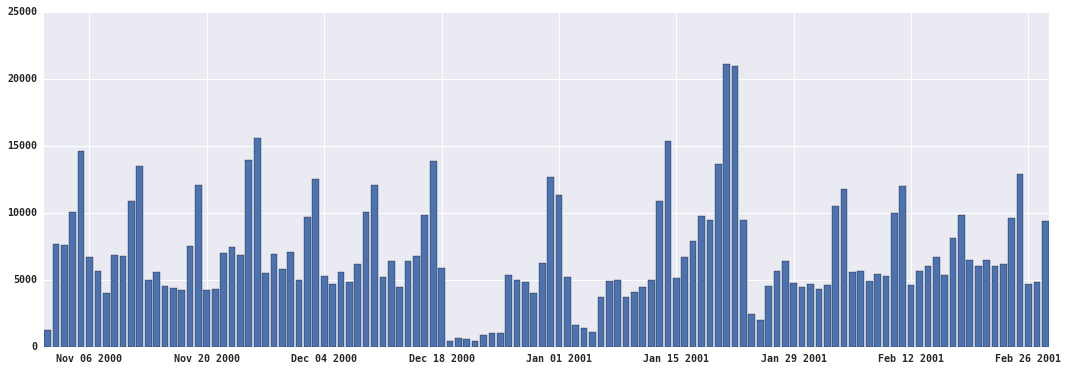

In [84]:
vc = full['day'].value_counts()

plt.bar(
    vc.index, vc.values, align='center'
)

Public holidays in the period:

- New year: 30/12/2000 - 1/1/2001

- Spring festival: 24/1 - 28/1/2001

Note:

- Some thing happened from 19/12 to 25/12/2000

- Spring festival increased sales

<Container object of 11 artists>

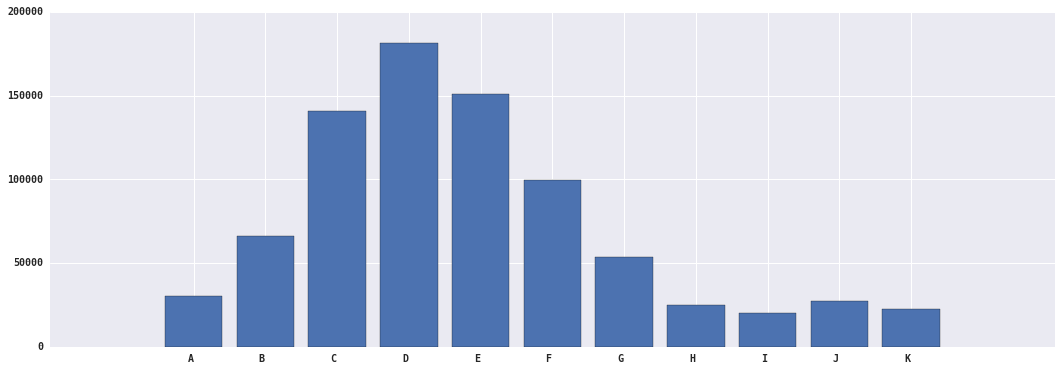

In [74]:
vc = full['age_group'].value_counts().sort_index()

plt.bar(
    range(len(vc.index)), vc.values, tick_label=vc.index, align='center'
)

<Container object of 8 artists>

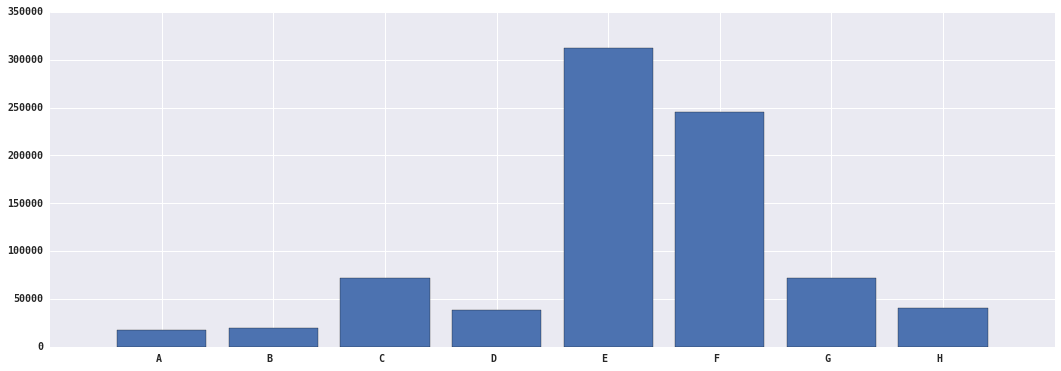

In [85]:
vc = full['residence_area'].value_counts().sort_index()

plt.bar(
    range(len(vc.index)), vc.values, tick_label=vc.index, align='center'
)

Note:

- `E` is the closest, then `F`
    
- `C` is the furthest 

<Container object of 120 artists>

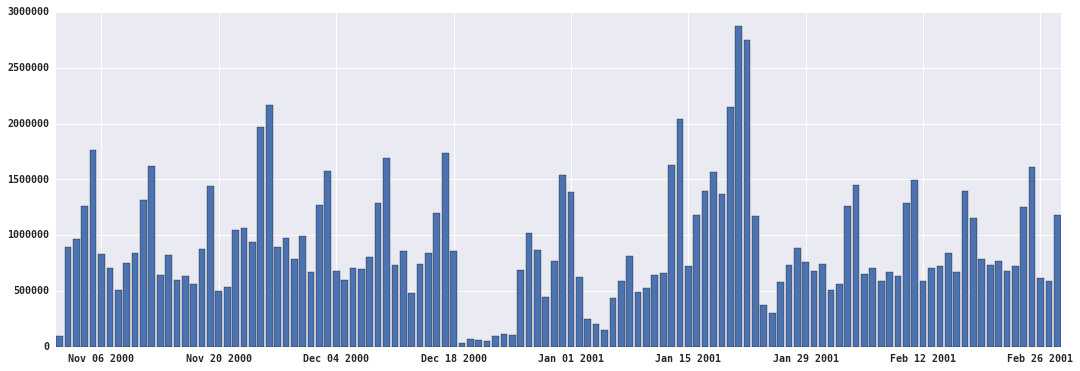

In [200]:
days = []
sales_prices = []

for day, data in full.groupby('day'):
    total_price = data.sum()['sales_price']
    
    days.append(day)
    sales_prices.append(total_price)

plt.bar(
    days, sales_prices, align='center'
)

# Seasonal product recommendation

Popular items on the weekly basis

In [162]:
full['week'] = full['day'].map(
    lambda day: day.weekofyear
)

In [180]:
popular_product = {}

In [181]:
LIMIT = 100

In [182]:
for week in full['week'].value_counts().index:
    df = full[
        full['week'] == week
    ]
    for code, count in df['product_id'].value_counts().head(LIMIT).iteritems():  # result from value_counts() is sorted 
        try:
            popular_product[code].append(
                (week, count)
            )
        except KeyError:
            popular_product[code] = [
                (week, count)
            ]

Find the all-time common ones (appearing more than 8 weeks, about 50% of the period)

In [183]:
FREQ_THRESHOLD_MAX = 8

In [184]:
all_time_common_products = []

for code, data in popular_product.iteritems():
    if len(data) > FREQ_THRESHOLD_MAX:
        all_time_common_products.append(code)

Find the least common ones (appearing just 1 week)

In [185]:
FREQ_THRESHOLD_MIN = 1

In [186]:
least_common_products = []

for code, data in popular_product.iteritems():
    if len(data) == FREQ_THRESHOLD_MIN:
        least_common_products.append(code)

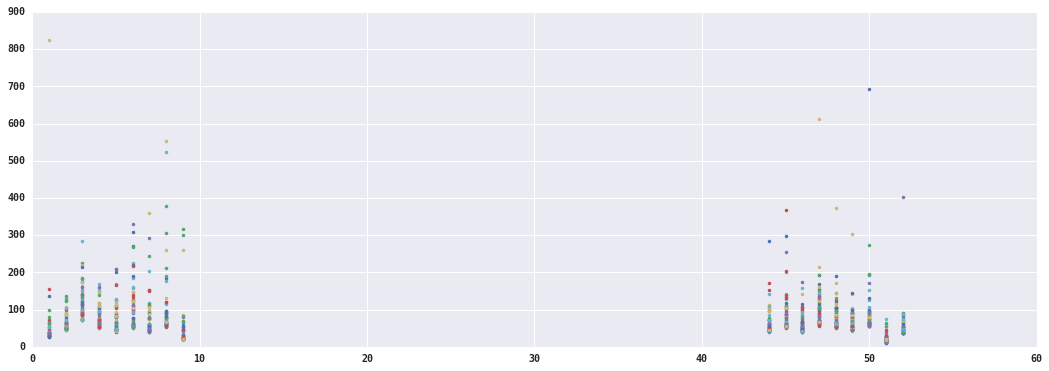

In [187]:
ax = plt.gca()

for code, data in popular_product.iteritems():
    if code not in all_time_common_products and code not in least_common_products:
        ax.plot(
            [it[0] for it in data],
            [it[1] for it in data],
            '.'
        )

Recommendation for the Spring festival

In [188]:
start = pd.Timestamp('2001-01-18')
end = pd.Timestamp('2001-01-24')

In [189]:
pre_spring_festival = full[
    (start < full['day']) & (full['day'] < end)
]

In [190]:
print '{} out of {} occured in the Pre Spring festival period'.format(
    len(pre_spring_festival), len(full)
)    

74613 out of 817741 occured in the Pre Spring festival period


In [193]:
FREQ_THRESHOLD_SPRING_FESTIVAL = 100

In [199]:
for code, count in pre_spring_festival['product_id'].value_counts().iteritems():
    if code not in all_time_common_products and \
        code not in least_common_products and \
        count > FREQ_THRESHOLD_SPRING_FESTIVAL:
            print '{:.0f}, {}'.format(code, count)

4710174053691, 308
4901550332077, 257
4710466101130, 240
4710043552102, 237
4710018004704, 236
4710154015206, 230
4710943101318, 212
4713327005035, 197
4710022101208, 192
4710085120093, 173
4710908111116, 166
4710128030037, 158
4710036012019, 151
4712697490816, 149
4710084225676, 149
719859796117, 148
723125485032, 146
4710085172696, 144
4014400901573, 144
4710321790509, 143
4713754987614, 142
4711022100017, 142
4710254049323, 141
4711258001256, 138
4710265847666, 137
7231254880206, 136
4711258004004, 131
4710046021100, 125
4710011401135, 124
4713754987607, 124
4934567661519, 120
4710011409056, 115
4710154620264, 113
723125488033, 112
4711258002505, 109
4710174018195, 109
4710174011790, 107
4901550152484, 104
